In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacytextblob.spacytextblob import SpacyTextBlob
plt.rcParams.update({"font.size": 12})
%matplotlib inline

# 1. Load Dataset

In [89]:
date_fmt = lambda x: datetime.utcfromtimestamp(int(x)).strftime("%Y-%m-%d")
# Load submissions data
df_submissions = pd.read_csv("data/submissions.csv", delimiter=";", parse_dates=["created_utc"],
                 date_parser=date_fmt, encoding="utf-8")
df_submissions.head()

# Load stock price data
# df_prices = pd.read_csv("data/SandP_500_all.csv", index_col="Date", delimiter=",", parse_dates=True, encoding="utf-8")
# display(df_prices.head())

,author,created_utc,id,link_flair_text,num_comments,removed_by_category,score,selftext,subreddit_subscribers,title,upvote_ratio
0,klabboy,2020-01-01,eib0co,Forex,0,moderator,1,NaN,772366,The halving will do nothing for Bitcoin’s price,NaN
1,juliflave666,2020-01-01,eib171,NaN,0,automod_filtered,1,NaN,772365,New year biatches,NaN
2,TheTimelessUsername,2020-01-01,eib22c,NaN,0,automod_filtered,1,NaN,772366,Investing is easy bro. Look at my charts,NaN
3,ILL3NITVM,2020-01-01,eib3bh,NaN,0,NaN,1,"Happy new year to everyone, stay hydrated &amp...",772368,HAPPY NEW YEAR!,NaN
4,seaisthememes,2020-01-01,eib3oe,Shitpost,0,moderator,1,NaN,772368,happy 2020 autists,NaN


In [3]:
display(df_submissions.info())
display(df_prices.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 700 entries, 2020-01-02 22:22:20 to 2021-03-31 18:38:29
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   author                 700 non-null    object 
 1   id                     700 non-null    object 
 2   link_flair_text        663 non-null    object 
 3   num_comments           700 non-null    int64  
 4   score                  700 non-null    int64  
 5   selftext               676 non-null    object 
 6   subreddit_subscribers  700 non-null    int64  
 7   title                  700 non-null    object 
 8   upvote_ratio           520 non-null    float64
dtypes: float64(1), int64(3), object(5)
memory usage: 54.7+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1050 entries, 2017-02-28 to 2021-04-29
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1050 non-null   float64
 1   High          1050 non-null   float64
 2   Low           1050 non-null   float64
 3   Close         1050 non-null   float64
 4   Volume        1050 non-null   int64  
 5   Dividends     1050 non-null   float64
 6   Stock Splits  1050 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 65.6 KB


None

In [4]:
df_submissions["link_flair_text"] = df_submissions["link_flair_text"].fillna("")
df_submissions["selftext"] = df_submissions["selftext"].fillna("")
df_submissions["upvote_ratio"] = df_submissions["upvote_ratio"].fillna(1.0)

# 2. Find Sentiment

## 2.1. Intialize pipline

<!-- ![nlp_pipeline](https://spacy.io/pipeline-fde48da9b43661abcdf62ab70a546d71.svg) -->

In [5]:
# @todo Handle stop words
# @todo Calculate weighted mean for sentiments using score + upvote_ratio + comments
# @todo Need to optimize the textblob statistical model
# nlp = spacy.load("en_core_web_lg")
nlp = spacy.blank("en")
if "spacytextblob" not in nlp.pipe_names:
    nlp.add_pipe("spacytextblob")
    nlp.rename_pipe("spacytextblob", "sentiment")
print(nlp.pipe_names)

['sentiment']


## 2.2. Find sentiment

In [6]:
df_submissions["title_polarity"] = 0.0
df_submissions["title_subjectivity"] = 0.0
df_submissions["body_polarity"] = 0.0
df_submissions["body_subjectivity"] = 0.0
df_submissions["polarity"] = 0.0

def get_sentiment(title, body):
    nlp_title = nlp(title)
    nlp_body = nlp(body)
    return pd.Series([nlp_title._.polarity, nlp_title._.subjectivity,
                      nlp_body._.polarity, nlp_body._.subjectivity])

df_submissions[["title_polarity", "title_subjectivity", "body_polarity", "body_subjectivity"]] = df_submissions.apply(lambda row: get_sentiment(row["title"], row["selftext"]), axis=1)
df_submissions["polarity"] = (df_submissions["title_polarity"] + df_submissions["body_polarity"])
df_submissions.head()

,author,id,link_flair_text,num_comments,score,selftext,subreddit_subscribers,title,upvote_ratio,title_polarity,title_subjectivity,body_polarity,body_subjectivity,polarity
created_utc,,,,,,,,,,,,,,
2020-01-02 22:22:20,Ardesic53,ej5dx9,Discussion,28,19,"Just because AMD hit its ATH, doesnt mean its ...",775223,Amd ATH,1.0,0.0,0.000000,-0.637500,0.762500,-0.637500
2020-01-02 22:57:41,Trident1000,ej5vt8,Technicals,250,79,The market is 24.41 PE and almost 19x forward ...,775245,Am I the only one concerned with these levels?,1.0,0.0,1.000000,-0.038194,0.489583,-0.038194
2020-01-03 15:45:50,itsonlyfiat,ejh4ga,,29,23,Because BTFD and stonks always go up..\r\nOn a...,775802,Am I the only retard buying same day calls on ...,1.0,-0.3,0.708333,-0.065000,0.520000,-0.365000
2020-01-08 07:02:58,CIARRAPUNGI,elpab7,Discussion,75,1,With all that happened today with Iran firing ...,780084,Profiting from Iran war thread,1.0,0.0,0.000000,-0.133333,0.295833,-0.133333
2020-01-08 14:13:25,bigbear0083,elt7sh,,8,1,#Good morning traders and investors of the r/w...,780861,"Today's Pre-Market News [Wednesday, January 8t...",1.0,0.0,0.000000,0.134145,0.563281,0.134145


## 2.3. Group by day

In [7]:
df_polarity = df_submissions.groupby(pd.Grouper(freq="D"))[["polarity"]].mean()
df_polarity = df_polarity.fillna(0)
display(df_polarity.head())

,polarity
created_utc,
2020-01-02,-0.337847
2020-01-03,-0.365000
2020-01-04,0.000000
2020-01-05,0.000000
2020-01-06,0.000000


# 4. Draw Plot

In [8]:
df_prices["price"] = (df_prices["High"] + df_prices["Low"]) / 2
display(df_prices.head())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,price
Date,,,,,,,,
2017-02-28,218.779483,219.038316,218.178624,218.594604,96961900,0.0,0,218.608470
2017-03-01,220.369463,222.153576,220.350971,221.654388,149158200,0.0,0,221.252273
2017-03-02,221.451009,221.460262,220.203067,220.258530,70246000,0.0,0,220.831665
2017-03-03,220.166084,220.572826,219.759343,220.397186,81974300,0.0,0,220.166084
2017-03-06,219.546728,220.119856,219.093764,219.740860,55391500,0.0,0,219.606810


In [9]:
# 455 rows
df_polarity_price = pd.concat([df_prices, df_polarity], axis=1, join="inner")
display(df_polarity_price[["polarity", "price"]])

,polarity,price
2020-01-02,-0.337847,316.738194
2020-01-03,-0.365000,315.427085
2020-01-06,0.000000,315.109074
2020-01-07,0.000000,315.935870
2020-01-08,0.000406,317.242151
...,...,...
2021-03-25,0.000000,387.224991
2021-03-26,0.000000,393.350006
2021-03-29,0.105202,394.779999
2021-03-30,-0.065825,394.235001


Text(0.5, 1.0, 'Stock polarity vs price by date')

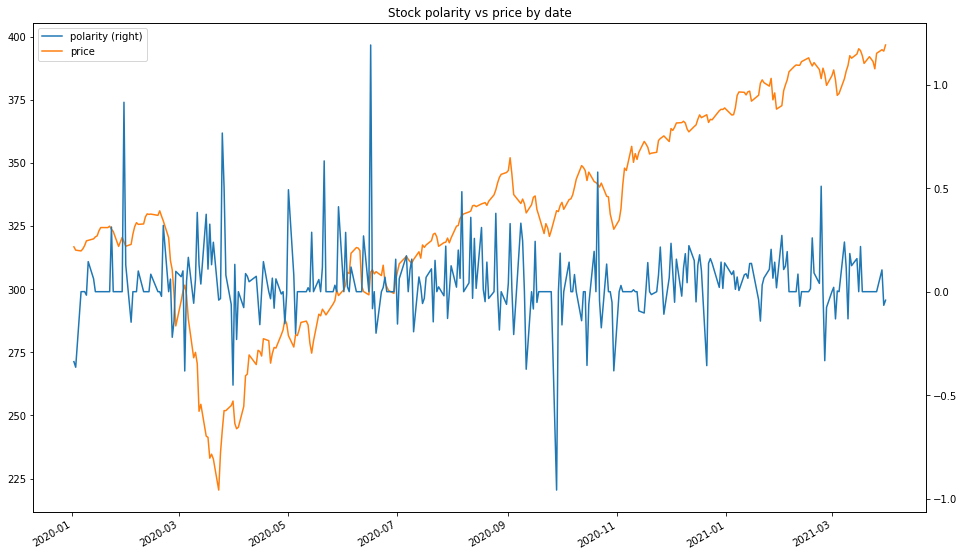

In [18]:
df_polarity_price[["polarity", "price"]].plot(secondary_y="polarity", figsize=(16, 10))
plt.title("Stock polarity vs price by date")

d:\msc\4. ss2021\digital business and consumer behavior project\project\venv\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
d:\msc\4. ss2021\digital business and consumer behavior project\project\venv\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
d:\msc\4. ss2021\digital business and consumer behavior project\project\venv\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
d:\msc\4. ss2021\digital business and consumer behavior project\project\venv\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


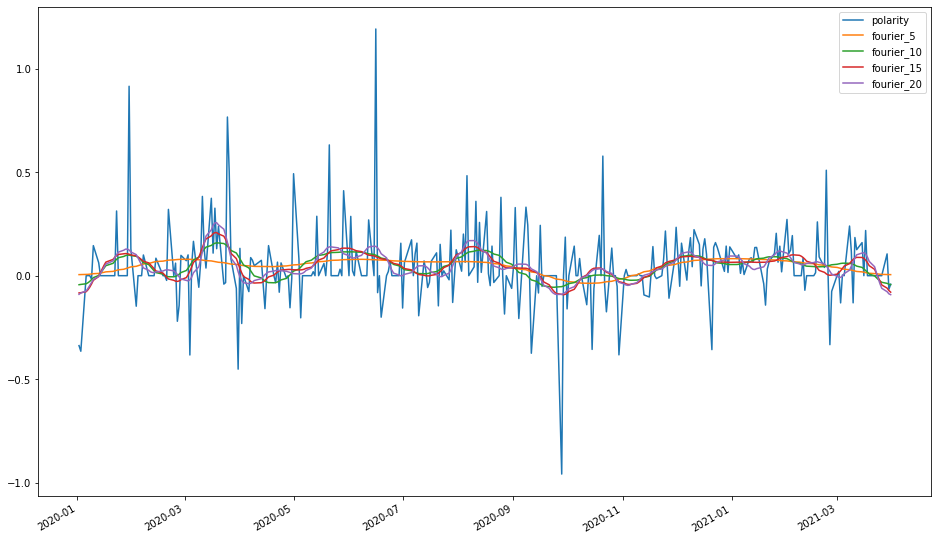

In [11]:
## Fourier transform

close_fft = np.fft.fft(np.asarray(df_polarity_price["polarity"].tolist()))
fft_df = pd.DataFrame({"fft": close_fft})
fft_df["absolute"] = fft_df["fft"].apply(lambda x: np.abs(x))
fft_df["angle"] = fft_df["fft"].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df["fft"].tolist())

for num_ in [5, 10, 15, 20]:
    fft_list_m10 = np.copy(fft_list); fft_list_m10[num_:-num_] = 0
    df_polarity_price["fourier_"+str(num_)] = np.fft.ifft(fft_list_m10)
    
df_polarity_price[["polarity", "fourier_5", "fourier_10", "fourier_15", "fourier_20"]].plot(figsize=(16, 10));

d:\msc\4. ss2021\digital business and consumer behavior project\project\venv\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:>

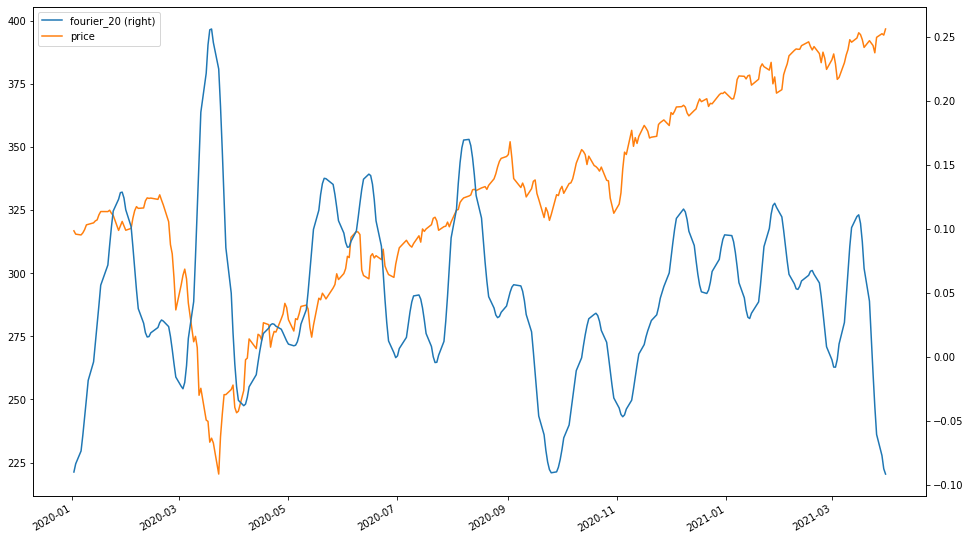

In [12]:
df_polarity_price[["fourier_20", "price"]].plot(secondary_y="fourier_20", figsize=(16, 10))

<ipython-input-13-4e7dea9c13f1>:6: ComplexWarning: Casting complex values to real discards the imaginary part
  df_polarity_price['norm_fourier5'] = sc.fit_transform(np.asarray(list([(float(x)) for x in df_polarity_price['fourier_5'].to_numpy()])).reshape(-1, 1))
<ipython-input-13-4e7dea9c13f1>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  df_polarity_price['norm_fourier10'] = sc.fit_transform(np.asarray(list([(float(x)) for x in df_polarity_price['fourier_10'].to_numpy()])).reshape(-1, 1))
<ipython-input-13-4e7dea9c13f1>:8: ComplexWarning: Casting complex values to real discards the imaginary part
  df_polarity_price['norm_fourier15'] = sc.fit_transform(np.asarray(list([(float(x)) for x in df_polarity_price['fourier_15'].to_numpy()])).reshape(-1, 1))
<ipython-input-13-4e7dea9c13f1>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  df_polarity_price['norm_fourier20'] = sc.fit_transform(np.asarray(list([(float(x)) for x in 

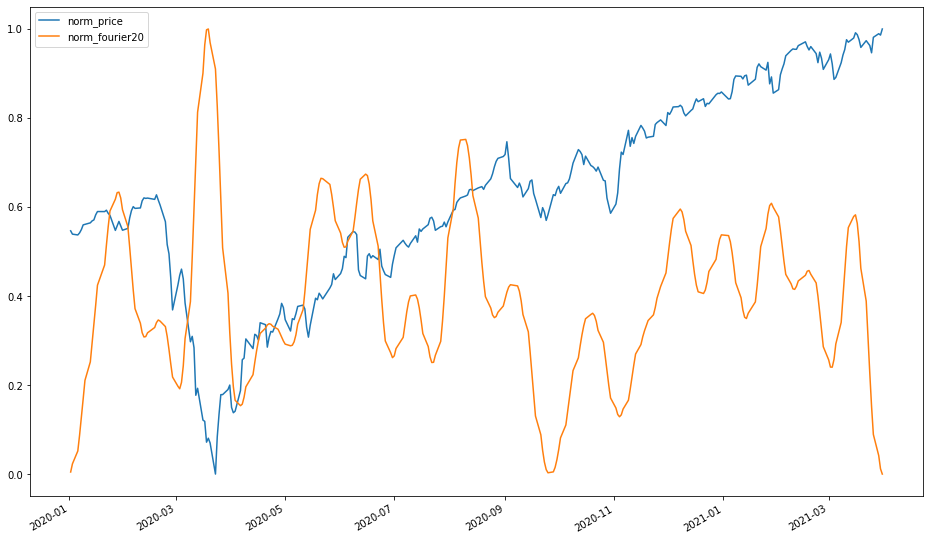

In [13]:
# Normalize
sc = MinMaxScaler(feature_range=(0,1))
df_polarity_price['norm_price'] = sc.fit_transform(df_polarity_price['price'].to_numpy().reshape(-1, 1))
df_polarity_price['price_log'] = np.log(df_polarity_price['price']/df_polarity_price['price'].shift(1))
df_polarity_price['norm_polarity'] = sc.fit_transform(df_polarity_price['polarity'].to_numpy().reshape(-1, 1))
df_polarity_price['norm_fourier5'] = sc.fit_transform(np.asarray(list([(float(x)) for x in df_polarity_price['fourier_5'].to_numpy()])).reshape(-1, 1))
df_polarity_price['norm_fourier10'] = sc.fit_transform(np.asarray(list([(float(x)) for x in df_polarity_price['fourier_10'].to_numpy()])).reshape(-1, 1))
df_polarity_price['norm_fourier15'] = sc.fit_transform(np.asarray(list([(float(x)) for x in df_polarity_price['fourier_15'].to_numpy()])).reshape(-1, 1))
df_polarity_price['norm_fourier20'] = sc.fit_transform(np.asarray(list([(float(x)) for x in df_polarity_price['fourier_20'].to_numpy()])).reshape(-1, 1))

df_polarity_price[['norm_price', 'norm_fourier20']].plot(figsize=(16, 10));

## Handle Emojis

In [14]:
nlp = spacy.blank("en")

emoji_config = {"lookup": {"🔥": "water"}}
if "emoji" not in nlp.pipe_names:
    nlp.add_pipe("emoji", config=emoji_config)
                
if "spacytextblob" not in nlp.pipe_names:
    nlp.add_pipe("spacytextblob")
    nlp.rename_pipe("spacytextblob", "sentiment")

print(nlp.pipe_names)

['emoji', 'sentiment']


In [15]:
doc = nlp("This is a test 🔥, 📈, 📉, 🚀, 👐, 💎, 🙌, 🐵, 🧨, 🌞, 🍀, 💥, 💪, 🤞, 🤑")
print(doc._.has_emoji)
print(doc._.emoji)
print(doc._.polarity)
print()
doc = nlp("This is another test")
print(doc._.has_emoji)
print(doc._.emoji)
print(doc._.polarity)

True
[('🔥', 4, 'water'), ('📈', 6, 'chart increasing'), ('📉', 8, 'chart decreasing'), ('🚀', 10, 'rocket'), ('👐', 12, 'open hands'), ('💎', 14, 'gem stone'), ('🙌', 16, 'raising hands'), ('🐵', 18, 'monkey face'), ('🧨', 20, 'firecracker'), ('🌞', 22, 'sun with face'), ('🍀', 24, 'four leaf clover'), ('💥', 26, 'collision'), ('💪', 28, 'flexed biceps'), ('🤞', 30, 'crossed fingers'), ('🤑', 32, 'money-mouth face')]
0.0

False
[]
0.0


In [16]:
df_emojis = df_submissions.copy()
df_emojis["emoji"] = ""

def has_emoji(title, body):
    nlp_title = nlp(title)
    nlp_body = nlp(body)
    emojis = nlp_title._.emoji + nlp_body._.emoji or ""
    return emojis

df_emojis["emoji"] = df_emojis.apply(lambda row: has_emoji(row["title"], row["selftext"]), axis=1)

In [17]:
df_emojis[df_emojis["emoji"] != ""][["emoji"]].head(50)

,emoji
created_utc,
2020-01-11 15:12:31,"[(®, 5283, registered), (®, 5536, registered),..."
2020-01-12 02:56:12,"[(🚀, 11, rocket), (🌙, 12, crescent moon), (🤣, ..."
2020-01-18 16:04:33,"[(®, 5580, registered), (®, 6079, registered),..."
2020-01-31 21:18:11,"[(🚀, 67, rocket)]"
2020-02-01 14:53:47,"[(®, 6183, registered), (®, 6435, registered),..."
2020-02-15 14:29:39,"[(®, 5912, registered), (®, 6165, registered),..."
2020-02-27 03:14:26,"[(📈, 0, chart increasing), (🌈, 34, rainbow), (..."
2020-02-29 02:34:28,"[(🌈, 12, rainbow), (🐻, 13, bear face)]"
2020-02-29 15:51:54,"[(®, 6094, registered), (®, 6267, registered),..."


In [90]:
df_submissions = df_submissions[df_submissions["removed_by_category"].isnull()]
df_submissions.drop("removed_by_category", axis=1, inplace=True)

In [91]:
nlp = spacy.blank("en")

if "emoji" not in nlp.pipe_names:
    nlp.add_pipe("emoji")
                
print(nlp.pipe_names)

['emoji']


In [92]:
df_emojis = df_submissions.copy()
df_emojis["emoji"] = ""

def get_emoji(title, body):
    doc = nlp(str(title) + " " + str(body))
    emojis = doc._.emoji
    return [emoji[0] for emoji in emojis]

df_emojis["emojis"] = df_emojis.apply(lambda row: get_emoji(row["title"], row["selftext"]), axis=1)

In [55]:
df_emojis["emojis"]

3                 []
5                 []
8                [🙏]
9                 []
10                []
             ...    
1197812           []
1197813           []
1197814    [🦍, 🦍, 🦍]
1197815           []
1197817           []
Name: emojis, Length: 300673, dtype: object

In [129]:
from collections import Counter

df_submissions_emojis = df_emojis.groupby(["created_utc"]).apply(lambda x: str(list(x["emojis"]))).to_frame("emojis").reset_index()
df_submissions_emojis

,created_utc,emojis
0,2020-01-01,"[[], [], ['🙏'], [], [], [], [], [], [], [], ['..."
1,2020-01-02,"[[], [], [], [], [], [], [], [], [], [], [], [..."
2,2020-01-03,"[[], [], [], [], [], [], [], [], [], [], ['🐻',..."
3,2020-01-04,"[[], [], [], [], [], [], [], [], [], ['®', '®'..."
4,2020-01-05,"[[], [], [], [], [], [], [], [], ['🌈', '💩', '💧..."
...,...,...
438,2021-03-27,"[[], ['💎', '💎'], [], [], [], [], ['🚀'], [], []..."
439,2021-03-28,"[[], [], [], [], ['🦍', '🙌', '🍌', '🤝', '🐒', '🧠'..."
440,2021-03-29,"[[], [], [], [], [], ['🙃'], [], [], [], [], []..."
441,2021-03-30,"[[], ['🚀', '🚀'], ['💎', '🙌'], [], [], [], ['🦍']..."


In [132]:
def sanitize_column(data):
    return data.replace("[", "").replace("]", "").replace(",", "").replace("'", "").replace(" ", "")

df_submissions_emojis["emojis"] = df_submissions_emojis["emojis"].apply(sanitize_column)
df_submissions_emojis["emojis"]

0                                                 🙏🐂👅🇺🇸🐻
1                                                  🐻🤜💡🇨🇳
2                          🐻🐻🐻🖕🐐✊🏽🤦🏻\u200d♂️🐐🐐🐐😂😁😎🐌🐌🐌🐌💦🤤
3                                               ®®®®®®®®
4                               🌈💩💧🚿🚿🥃🥃👌👌😘😘🅱😬🤪😂🤷\u200d♀️
                             ...                        
438    💎💎🚀🚀🚀🚀☀️😎😎😎😎🦍🐰🦧🐶🐕🐩🦴🐾💎🤲🚀🚀🚀🌕🌕🚀🚀🚀🥺🐑🦍🐺🦍🦍🍌🍌🍌🙌💎🙌🍌🦍🖕🏻...
439    🦍🙌🍌🤝🐒🧠🚀🙌🏼💎🦍💎🤲💎🤲💎🤲🦍💎🤲🦍💎🤲🦍💎🤲🦍🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀...
440    🙃🚀🚀🚀💎🙌🏻🚀🚀🚀🦍🦍🦍💜🚀🚀🚀🚀🚀🚀💸💸💸💸💸🌕🌕🚀🚀🚀💎🖐🏽💎🖐🏽💎🖐🏽🚀🚀🚀🚀🚀🚀🚀...
441    🚀🚀💎🙌🦍🍌🍌🚀💎🙌🍌🦍🚀🚀🚀🚴🌕🚀🚀🚀🚀🚀🚀🚀🚀💎💎💎💎🚀🚀🚀🚀💎💎🦍🙏👶💪🚀🚀🚀🚀🚀🐂🚀...
442    👍👍🤣🙏🏾🦍🚀👍🏻🚀🚀🚀💴💰💬🐰📈⏰🤑🚀🚀🚀🚀🦍💎👐🦍🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀...
Name: emojis, Length: 443, dtype: object

In [133]:
df_submissions_emojis["emojis"] = df_submissions_emojis.apply(lambda x: Counter(x["emojis"]), axis=1)

In [136]:
df_submissions_emojis["emojis"]

0       {'🙏': 1, '🐂': 1, '👅': 1, '🇺': 1, '🇸': 1, '🐻': 1}
1               {'🐻': 1, '🤜': 1, '💡': 1, '🇨': 1, '🇳': 1}
2      {'🐻': 3, '🖕': 1, '🐐': 4, '✊': 1, '🏽': 1, '🤦': ...
3                                               {'®': 8}
4      {'🌈': 1, '💩': 1, '💧': 1, '🚿': 2, '🥃': 2, '👌': ...
                             ...                        
438    {'💎': 19, '🚀': 59, '☀': 1, '️': 1, '😎': 13, '🦍...
439    {'🦍': 57, '🙌': 8, '🍌': 7, '🤝': 1, '🐒': 2, '🧠':...
440    {'🙃': 3, '🚀': 528, '💎': 74, '🙌': 34, '🏻': 9, '...
441    {'🚀': 281, '💎': 104, '🙌': 41, '🦍': 86, '🍌': 6,...
442    {'👍': 4, '🤣': 7, '🙏': 4, '🏾': 5, '🦍': 143, '🚀'...
Name: emojis, Length: 443, dtype: object

In [83]:
print(Counter(['a', 'b', 'c', 'a', 'b', 'b']))

Counter({'b': 3, 'a': 2, 'c': 1})


In [50]:
doc = nlp("This is a test 🔥, 📈, 📉, 🚀, 👐, 💎, 🙌, 🐵, 🧨, 🌞, 🍀, 💥, 💪, 🤞, 🤑")
[emoji[0] for emoji in doc._.emoji]

['🔥', '📈', '📉', '🚀', '👐', '💎', '🙌', '🐵', '🧨', '🌞', '🍀', '💥', '💪', '🤞', '🤑']